In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [12]:
raw_benchmark_results = pd.read_csv('../benchmarks/2020-11-21-optimized.csv')

if 'generation_config_i' not in raw_benchmark_results.columns:
    # HACK Old benchmarks did not have generation_config_i. This adds it, but in a completely hardcoded unstable way.
    # This is sort of ok, since there was only 1 old benchmark like this.
    raw_benchmark_results['generation_config_i'] = np.arange(len(raw_benchmark_results)) // 18

raw_benchmark_results.sample(5)

,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,micros_until_len,generation_config_i
7618,independent,44,1.0,0.0,zipf,0,1,own_sequential,NaN,206,423
5180,addremove,113,0.8,0.0,zipf,2,2,own_mpi,8.0,29582,287
5326,addremove,292,1.0,0.5,zipf,2,1,own_sequential,NaN,1201,295
6755,addremove,17,0.4,1.0,zipf,0,2,own_sequential,NaN,118,375
3945,addremove,1,1.0,1.0,zipf,0,0,own_sequential,NaN,26,219


In [18]:
indexed_benchmark_results = raw_benchmark_results.set_index(['generation_config_i', 'regen_i', 'diff_program', 'repetition_i'])
indexed_benchmark_results

input_strategy  \
generation_config_i regen_i diff_program   repetition_i                  
0                   0       own_mpi        0                 addremove   
                                           1                 addremove   
                                           2                 addremove   
                            own_sequential 0                 addremove   
                                           1                 addremove   
...                                                                ...   
459                 2       own_mpi        1                    remove   
                                           2                    remove   
                            own_sequential 0                    remove   
                                           1                    remove   
                                           2                    remove   

                                                         input_length_1  \
generation_config_i regen_i diff_program   repetition_i                   
0                   0       own_mpi        0                       1940   
                                           1                       1940   
                                           2                       1940   
                            own_sequential 0                       1940   
                                           1                       1940   
...                                                                 ...   
459                 2       own_mpi        1                         17   
                                           2                         17   
                            own_sequential 0                         17   
                                           1                         17   
                                           2                         17   

                                                         input_change_strength  \
generation_config_i regen_i diff_program   repetition_i                          
0                   0       own_mpi        0                               0.8   
                                           1                               0.8   
                                           2                               0.8   
                            own_sequential 0                               0.8   
                                           1                               0.8   
...                                                                        ...   
459                 2       own_mpi        1                               0.8   
                                           2                               0.8   
                            own_sequential 0                               0.8   
                                           1                               0.8   
                                           2                               0.8   

                                                         input_chunkiness  \
generation_config_i regen_i diff_program   repetition_i                     
0                   0       own_mpi        0                          0.5   
                                           1                          0.5   
                                           2                          0.5   
                            own_sequential 0                          0.5   
                                           1                          0.5   
...                                                                   ...   
459                 2       own_mpi        1                          1.0   
                                           2                          1.0   
                            own_sequential 0                          1.0   
                                           1                          1.0   
                                           2                          1.0   

                                                

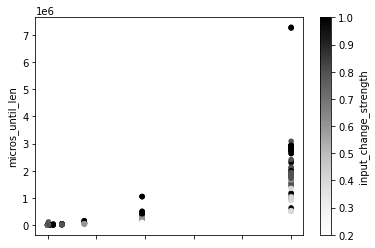

In [31]:
temp = indexed_benchmark_results.groupby(['generation_config_i', 'regen_i', 'diff_program']).min()
temp.xs('own_mpi', level='diff_program').plot.scatter('input_length_1', 'micros_until_len', c='input_change_strength');

In [76]:
unique_regen_i_values = sorted(np.unique(indexed_benchmark_results.index.get_level_values('regen_i').values))

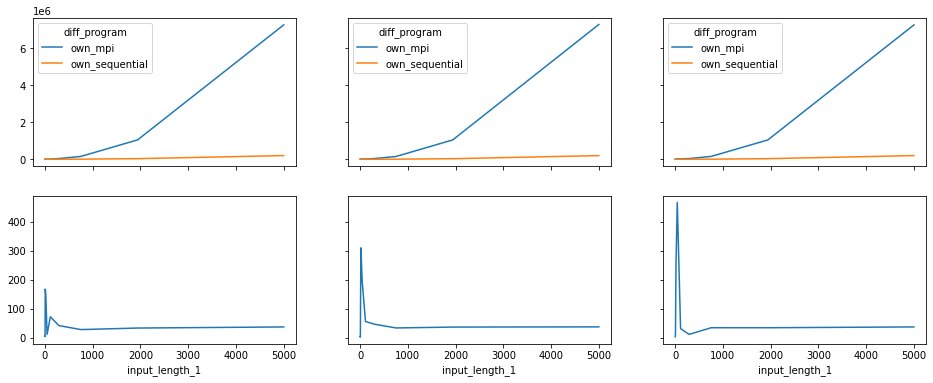

In [76]:
fig, ax = plt.subplots(2, len(unique_regen_i_values), figsize=(16, 6), sharex=True, sharey='row')
for regen_i in unique_regen_i_values:
    temp = indexed_benchmark_results.groupby(['generation_config_i', 'regen_i', 'diff_program']).min()
    temp = temp[temp['input_strategy'] == 'independent']
    temp = temp.xs(regen_i, level='regen_i')
    temp = temp.set_index('input_length_1', append=True)
    temp = temp.unstack('diff_program')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()

    temp.plot(ax=ax[0][regen_i]);
    (temp.own_mpi / temp.own_sequential).plot(ax=ax[1][regen_i]);

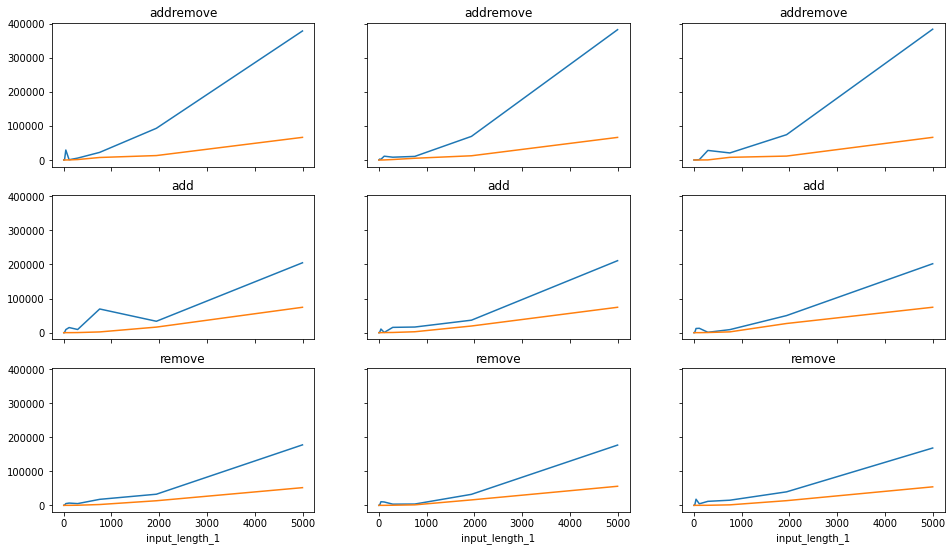

In [213]:
fig, ax = plt.subplots(3, len(unique_regen_i_values), figsize=(16, 9), sharex=True, sharey=True)
for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
    for regen_i in unique_regen_i_values:
        temp = indexed_benchmark_results.groupby(['generation_config_i', 'regen_i', 'diff_program']).min()
        temp = temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == 0.2) & (temp['input_chunkiness'] == 0)]
        temp = temp.xs(regen_i, level='regen_i')
        temp = temp.set_index('input_length_1', append=True)
        temp = temp.unstack('diff_program')['micros_until_len']
        temp = temp.droplevel('generation_config_i')
        temp = temp.sort_index()

        temp.plot(ax=ax[input_strategy_i][regen_i], legend=False, title=input_strategy);

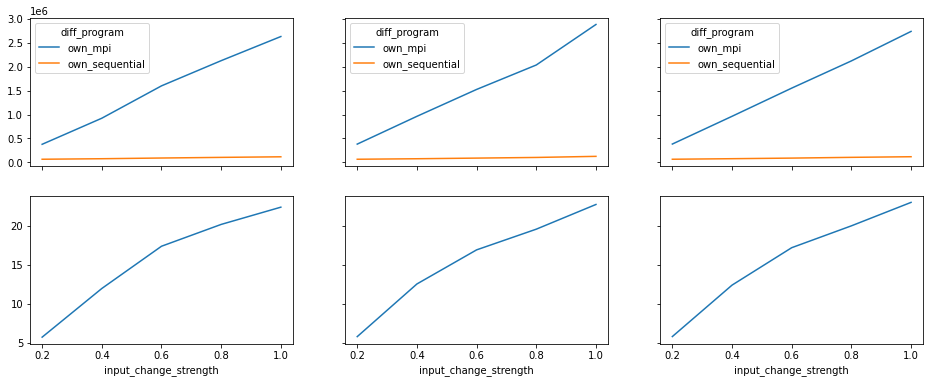

In [158]:
fig, ax = plt.subplots(2, len(unique_regen_i_values), figsize=(16, 6), sharex=True, sharey='row')
for regen_i in unique_regen_i_values:
    temp = indexed_benchmark_results.groupby(['generation_config_i', 'regen_i', 'diff_program']).min()
    temp = temp[(temp['input_strategy'] == 'addremove') & (temp['input_length_1'] == temp['input_length_1'].max()) & (temp['input_chunkiness'] == 0)]
    temp = temp.xs(regen_i, level='regen_i')
    temp = temp.set_index('input_change_strength', append=True)
    temp = temp.unstack('diff_program')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()

    temp.plot(ax=ax[0][regen_i]);
    (temp.own_mpi / temp.own_sequential).plot(ax=ax[1][regen_i]);

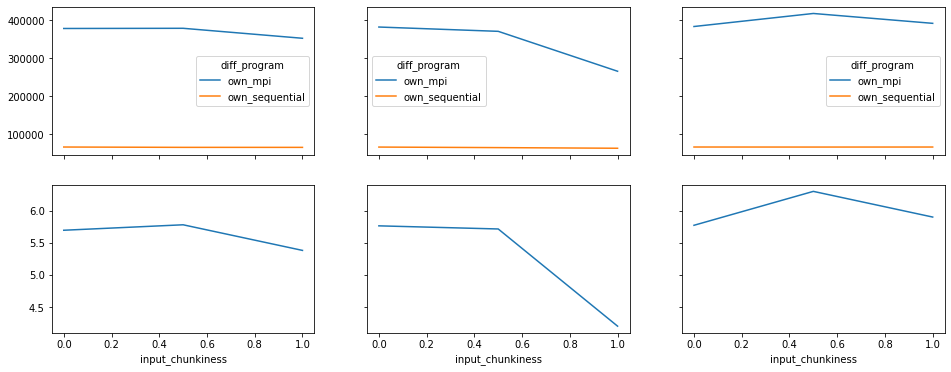

In [168]:
fig, ax = plt.subplots(2, len(unique_regen_i_values), figsize=(16, 6), sharex=True, sharey='row')
for regen_i in unique_regen_i_values:
    temp = indexed_benchmark_results.groupby(['generation_config_i', 'regen_i', 'diff_program']).min()
    temp = temp[(temp['input_strategy'] == 'addremove') & (temp['input_length_1'] == temp['input_length_1'].max()) & (temp['input_change_strength'] == 0.2)]
    temp = temp.xs(regen_i, level='regen_i')
    temp = temp.set_index('input_chunkiness', append=True)
    temp = temp.unstack('diff_program')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()

    temp.plot(ax=ax[0][regen_i]);
    (temp.own_mpi / temp.own_sequential).plot(ax=ax[1][regen_i]);

0.004347826086956522


,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,mpi_procs,micros_until_len
0,add,2,0.4,0.0,zipf,8.0,111
1,add,1,1.0,0.5,zipf,8.0,147
2,independent,2,1.0,0.0,zipf,8.0,235
3,addremove,2,1.0,0.0,zipf,8.0,136
4,add,1,0.4,0.5,zipf,8.0,105
5,add,1,0.4,0.5,zipf,8.0,105
6,addremove,2,0.6,0.5,zipf,8.0,162
7,remove,6,0.2,0.5,zipf,8.0,2640
8,remove,6,0.2,0.5,zipf,8.0,2640
9,remove,1940,0.2,0.0,zipf,8.0,40127


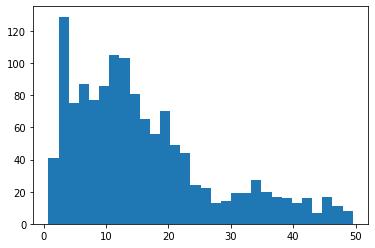

In [204]:
temp = indexed_benchmark_results['micros_until_len'].unstack('diff_program')
print((temp.own_mpi < temp.own_sequential).mean())

hist_values = temp.own_mpi / temp.own_sequential
hist_values = hist_values[(hist_values < 50) & (temp.own_sequential > 1000)]
plt.hist(hist_values, bins=30);

beaten_rows = []
for generation_config_i in temp[temp.own_mpi < temp.own_sequential].index.get_level_values('generation_config_i'):
    beaten_rows.append(indexed_benchmark_results.xs(generation_config_i, level='generation_config_i').iloc[0].to_dict())
pd.DataFrame(beaten_rows)